### Specialized Eigenvalue Containment

We noticed that if spectral radius was preserved, then the eigenvalues of the original were included in the spectrum of the specialized graph.

In [186]:
import numpy as np
from scipy import linalg as la
from specializeGraph import *

In [59]:
howMany = 3000
n = 4
stable = 0
notWork = []
for i in range(howMany):
    A, base = randomGraph(n,base=True)
    sA = specializeGraph(A,base)
    
    eigs = np.round(np.linalg.eig(laplacian(A))[0],5)
    sEigs = np.round(np.linalg.eig(laplacian(sA))[0],5)
    if A.shape[0] < sA.shape[0]:
        if np.isclose(max(eigs),max(sEigs)):
            stable += 1
            if not set(eigs).issubset(sEigs):
                notWork.append((A,base))
                
print("{}/{} dont work".format(len(notWork),stable))

47/301 dont work


In [57]:
for M in notWork:
    A,base = M
    sA = specializeGraph(A,base)
    eigs = np.round(np.linalg.eig(laplacian(A))[0],5)
    sEigs = np.round(np.linalg.eig(laplacian(sA))[0],5)
    print("Eigs: {}".format(eigs))
    print("sEigs: {}".format(sEigs))

Eigs: [ 2.  3. -0.  2.]
sEigs: [ 3.  3.  1. -0.  1.  1.]
Eigs: [ 2.  2.  1. -0.]
sEigs: [-0.     +0.e+00j  2.00001+1.e-05j  2.00001-1.e-05j  1.99999+0.e+00j
  1.     +0.e+00j  1.     +0.e+00j  1.     +0.e+00j  1.     +0.e+00j]
Eigs: [0.58579 4.      3.41421 0.     ]
sEigs: [4. 3. 0. 1. 1. 1.]
Eigs: [ 3.  3. -0.  2.]
sEigs: [3. 3. 0. 1. 1. 1.]


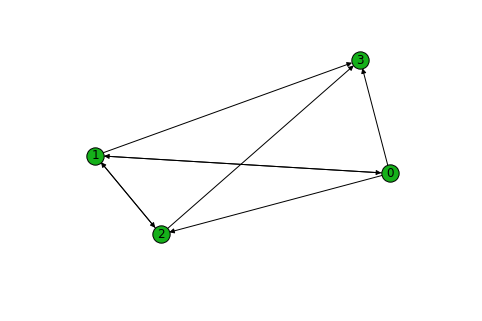

Spec: 3.0
[0, 2]


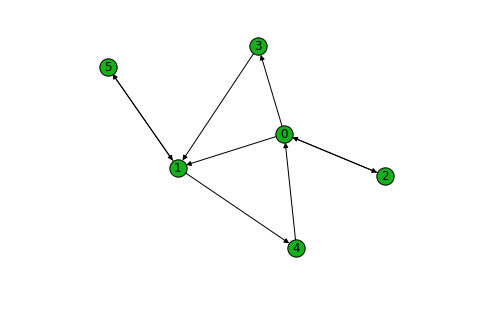

Spec 3.00000002837


In [58]:

drawGraph(M[0])
print("Spec: {}".format(spectralRad(laplacian(M[0]))))
print(M[1])
sA = specializeGraph(*M)
drawGraph(sA)
print("Spec {}".format(spectralRad(laplacian(sA))))

### Do all directed Laplacians have linearly independent eigenvectors?

In [31]:
notIndEVec = []
howMany = 100000
for i in range(howMany):
    G = randomGraph(4)
    L = laplacian(G[0])
    eig,vec = np.linalg.eig(L)
    try:
        np.linalg.inv(vec)
    except Exception:
        notIndEVec += [G[0]]
        
print("There are {} / {} graphs with lin-dep e-vecs".format(len(notIndEVec),howMany))

There are 120 / 100000 graphs with lin-dep e-vecs


The answer is no. There are strongly connected graphs whose directed laplacian have linearly dependent eigenvectors

In [27]:
import networkx as nx

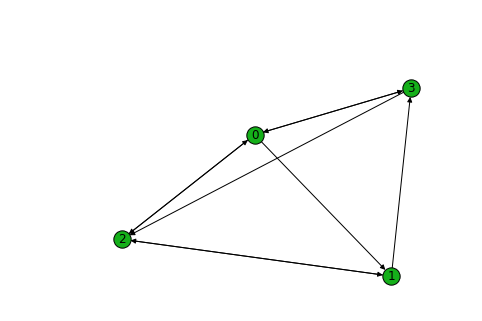

[[ 2.  0. -1. -1.]
 [-1.  2. -1.  0.]
 [-1. -1.  3. -1.]
 [-1. -1.  0.  2.]]
[[ 0.75592895 -0.5         0.75592895  0.75592895]
 [-0.37796447 -0.5        -0.37796447 -0.37796447]
 [-0.37796447 -0.5        -0.37796447 -0.37796447]
 [-0.37796447 -0.5        -0.37796447 -0.37796447]]


In [34]:
for G in notIndEVec:
    laplacian(G)
    if nx.is_strongly_connected(nx.DiGraph(G)):
        drawGraph(G)
        print(laplacian(G))
        print(np.linalg.eig(laplacian(G))[1])
        break


### How much do they occur?

In [41]:
print("n\t Percent Lin Dep EVec")
for n in range(3,20):
    linDep = 0.
    howMany = 100000
    for i in range(howMany):
        G = randomGraph(n)
        L = laplacian(G[0])
        eig,vec = np.linalg.eig(L)
        try:
            np.linalg.inv(vec)
        except np.linalg.LinAlgError:
            linDep += 1
            
    print("{}\t{}".format(n,linDep/howMany))
            
        


n	 Percent Lin Dep EVec
3	0.0
4	0.0012
5	0.00064
6	0.0008
7	0.00029
8	0.0001
9	7e-05
10	0.00031
11	7e-05
12	5e-05
13	2e-05
14	5e-05
15	4e-05
16	1e-05
17	0.0
18	1e-05
19	1e-05


### Find some transformations

In [216]:
Transforms = []
for i in range(1000):
    G,base = randomGraph(4)
    L = laplacian(G)
    sL = laplacian(specializeGraph(G,base))
    n = L.shape[0]
    m = sL.shape[0]
    cont = True
    if n < m:
        #If the graph does not become more unstable
        if np.isclose(spectralRad(sL),spectralRad(L)):
            lamba,Q = np.linalg.eig(L)
            Q = Q.dot(np.diag([1./la.norm(q) for q in Q.T]))
            lamba = np.round(lamba,5)
            
            Mu,eVec = np.linalg.eig(sL)
            eVec = eVec.dot(np.diag([1./la.norm(v) for v in eVec.T]))
            Mu = np.round(Mu,5)
            V = np.zeros((m,m))
            
            #And the pre spec. eigenvalues are a subset
            if set(lamba).issubset(Mu):
                #And the eigenvectors are lin-ind
                if np.linalg.det(eVec) != 0:
                    perm = []
                    for l in lamba:
                        i = np.where(Mu==l)[0]
                        
                        if len(i) == 0:
                            cont == False
                            break
                        else:
                            i = i[0]
                            
                        perm+=[i]
                        Mu[i] = np.inf
                        
                    if cont:    
                        loc = np.where(Mu!=np.inf)[0]
                        perm += list(loc)
                        V = eVec[:,perm]
                        Q = np.hstack((Q,np.zeros((n,int(m-n)))))
                        T = Q.dot(np.linalg.inv(V))
                        Transforms += [(G,base,T)]
                    
                    
                



In [217]:
len(Transforms)

74

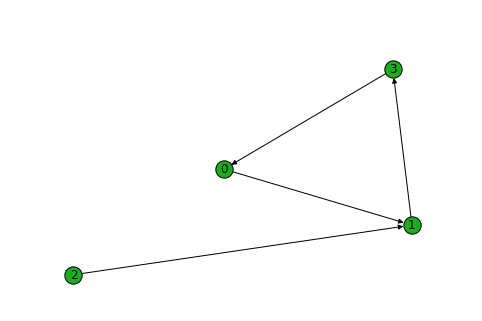

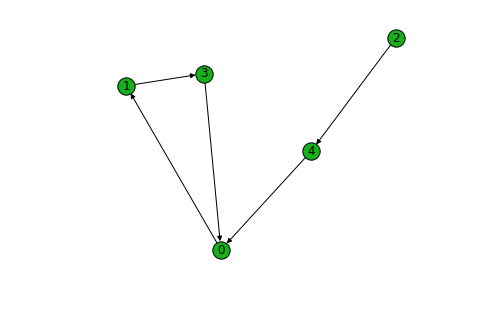

4.62464003201793


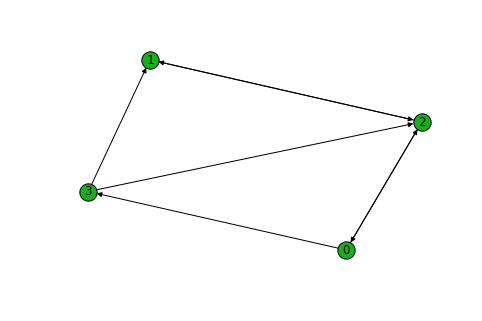

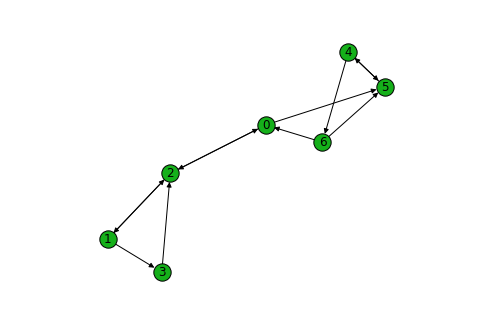

1.6318588238991514


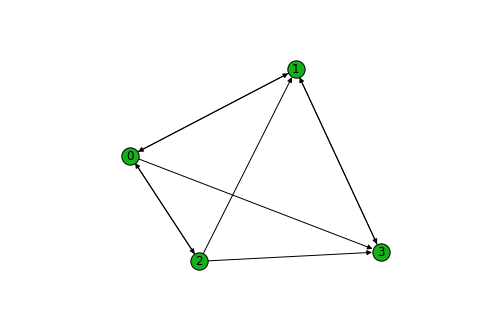

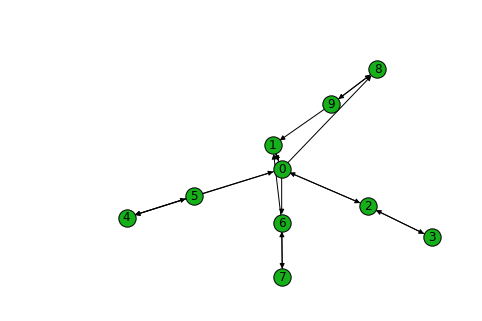

3.9411942187078606


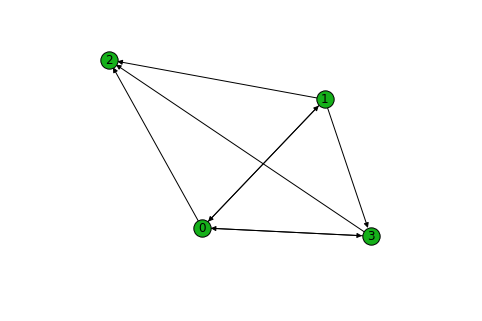

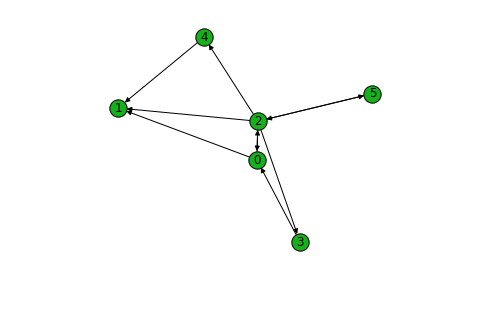

2.6362413113217866


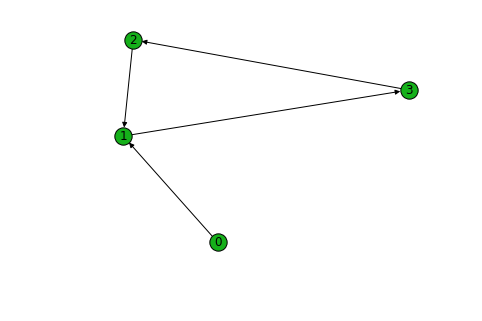

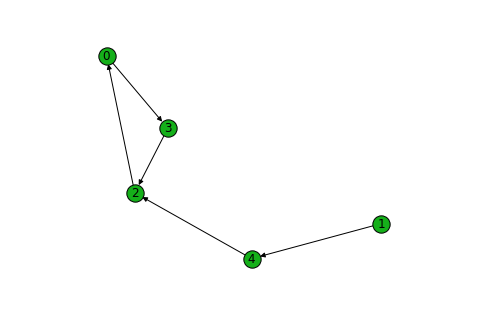

1.811552033190218


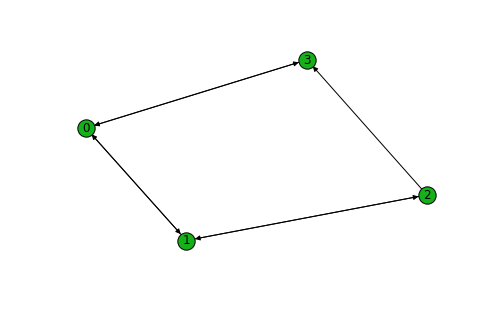

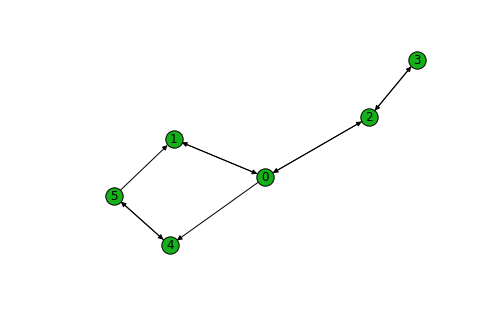

2.9242093699538168


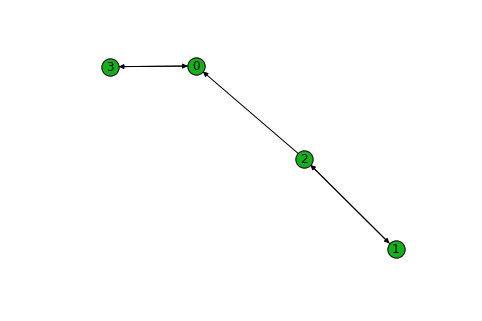

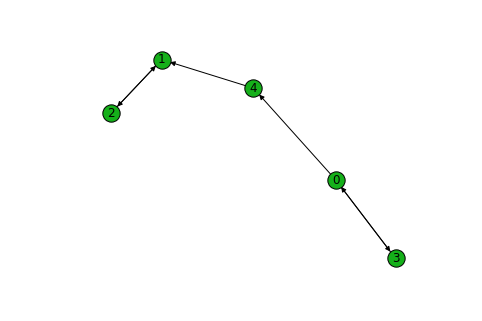

3.1403547674630405


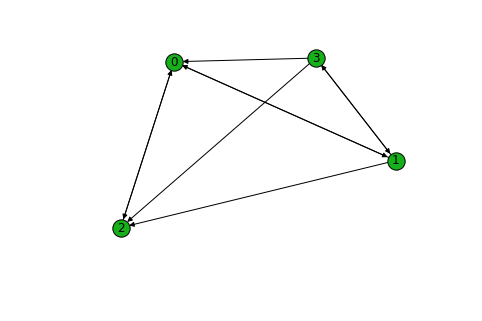

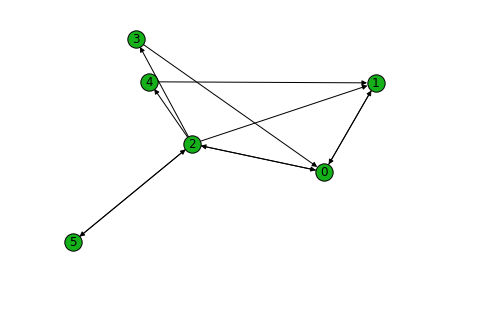

2.318182721171126


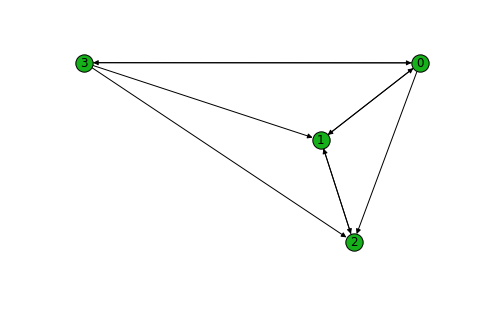

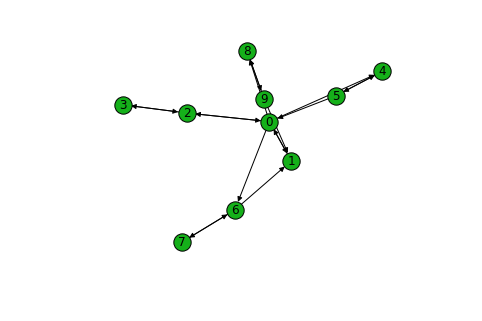

4.330125882680571


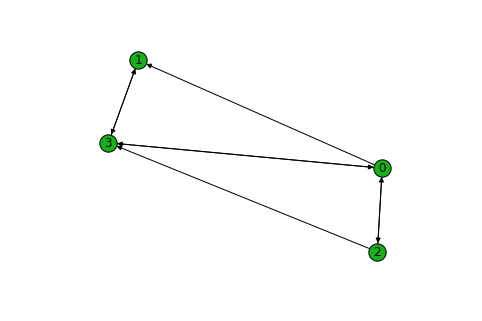

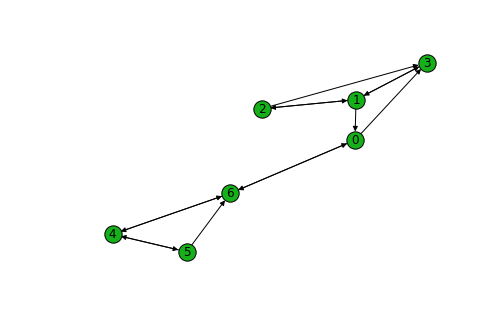

17.465766035581986


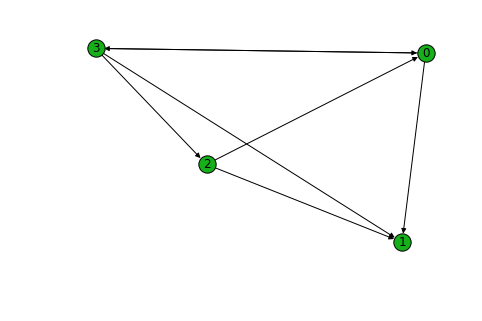

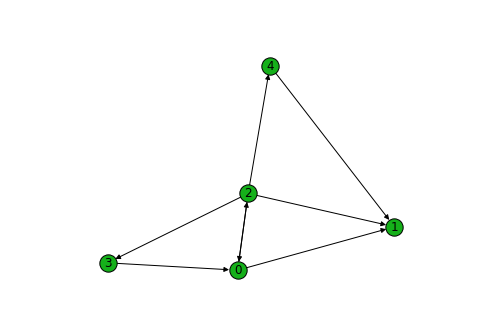

87110308.37602791


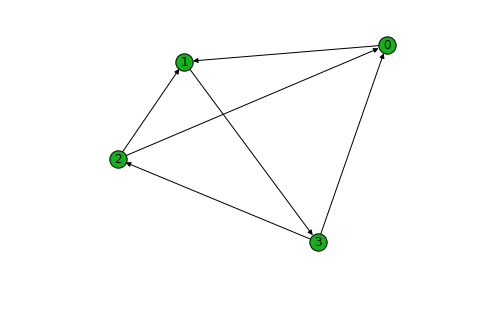

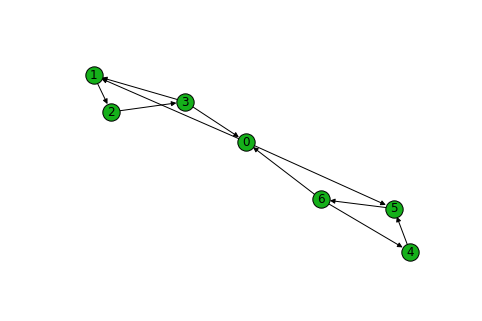

3.7360659676243078


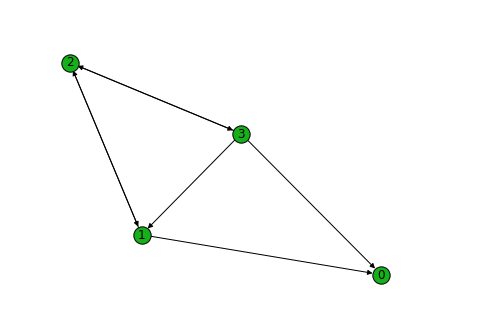

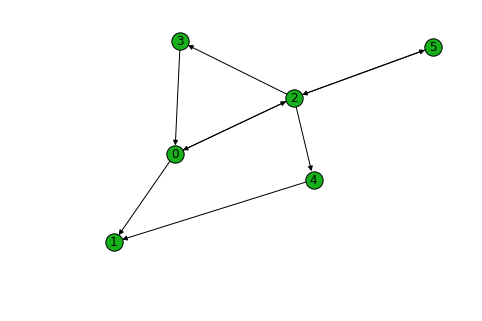

3.7725498000905544


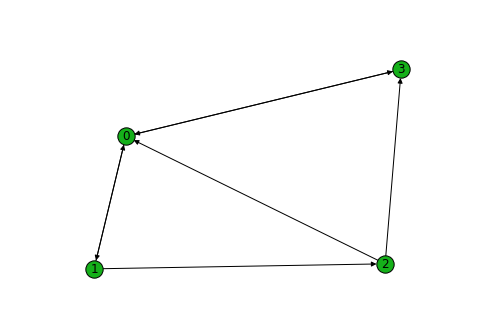

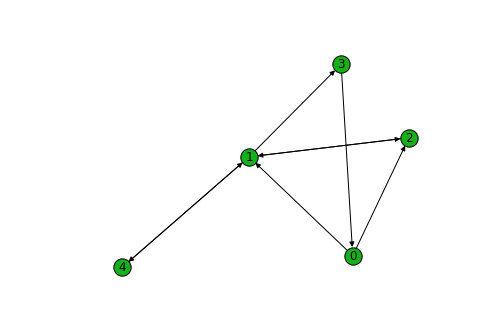

1.8676422034964808


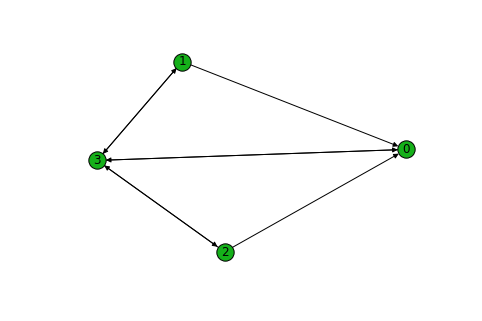

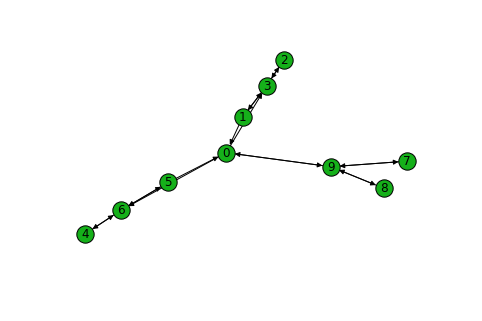

6.8488626979496905


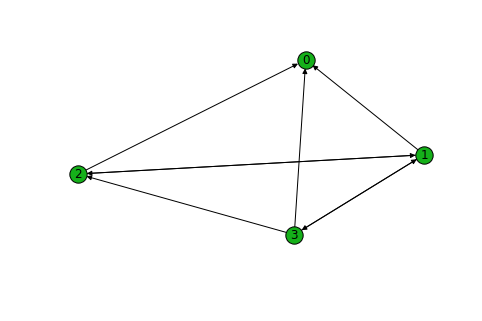

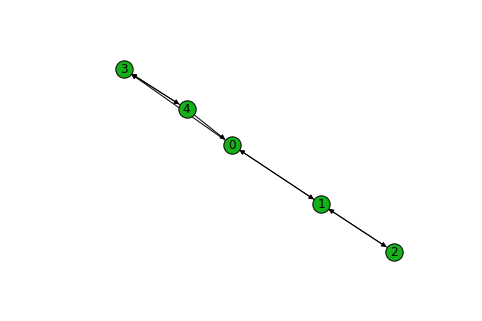

3.5035186762337727


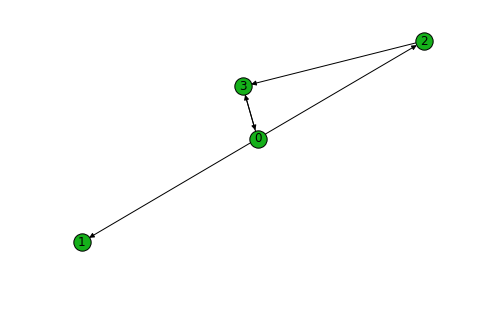

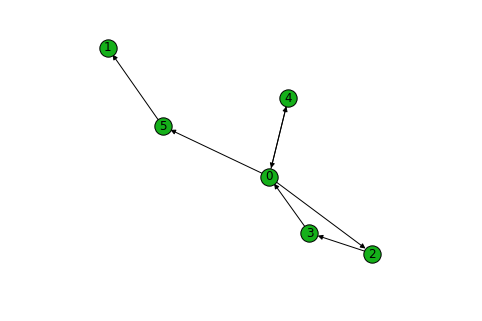

6194962289148032.0


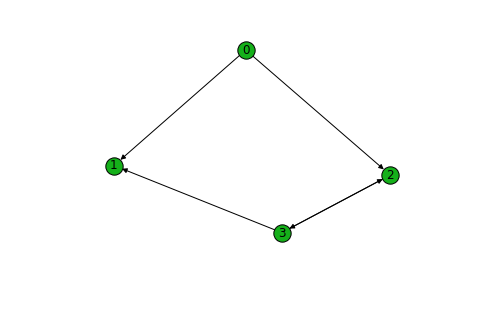

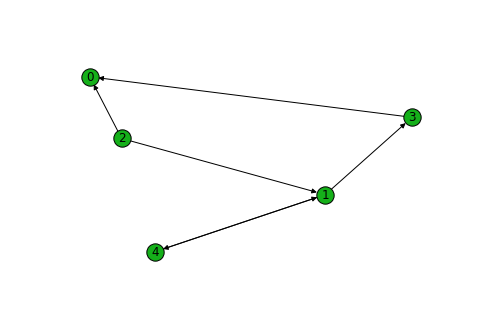

1.9877157971622037


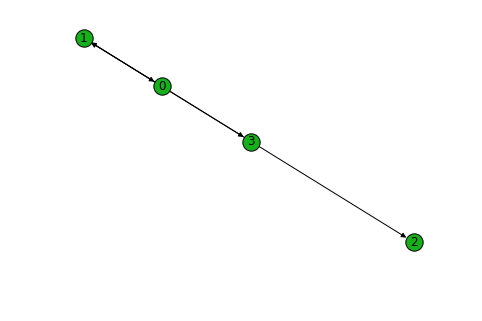

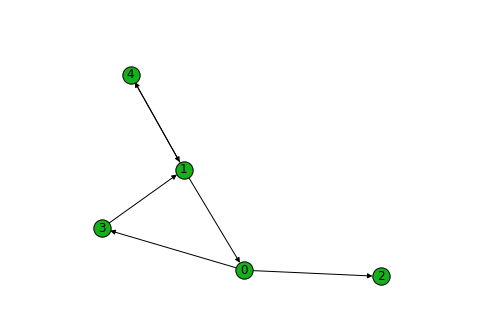

70294016.55707215


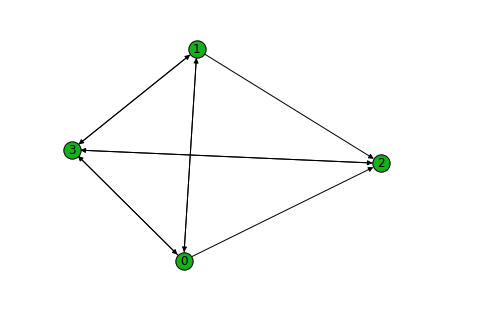

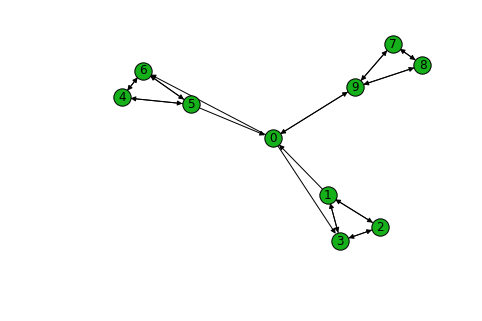

289284817974560.94


In [218]:
for i in range(20):
    G,base,T = Transforms[i]
    drawGraph(G)
    drawGraph(specializeGraph(G,base))
    print(la.norm(T,ord=2))

In [219]:
for i in range(20):
    G,base,T = Transforms[i]
    U,S,V = la.svd(T)
    print(S)

[4.62464003 1.21568185 1.         0.28123679]
[1.63185882 1.34925619 0.9211565  0.72961554]
[3.94119422 2.14021868 1.43937474 0.89822107]
[2.63624131 1.04694501 0.98525325 0.59913469]
[1.81155203 1.02227901 1.         0.85378741]
[2.92420937 1.03483199 1.01628032 0.40571544]
[3.14035477 2.2525975  0.60418229 0.4136135 ]
[2.31818272 1.48289473 0.91839615 0.46812674]
[4.33012588 2.10872198 1.3456479  0.88754793]
[17.46576604  1.34136073  1.02085985  0.81655996]
[8.71103084e+07 2.04057779e+00 9.27487711e-01 7.04056249e-01]
[3.73606597 2.36839102 1.24190029 0.9442449 ]
[3.7725498  1.36200807 1.07305967 0.41248424]
[1.8676422  1.24766392 0.99847812 0.70129404]
[6.8488627  1.83478154 1.07968208 0.88030609]
[3.50351868 1.60555684 1.17447643 0.56505627]
[6.19496229e+15 8.01415806e+07 9.23364111e-01 1.65682471e-09]
[1.9877158  1.15934882 1.08158205 0.85538332]
[7.02940166e+07 4.02298093e+00 8.77604556e-01 1.48248870e-08]
[2.89284818e+14 1.00226108e+14 4.74402280e+00 9.37001670e-01]
